In [1]:
import h5py
import numpy as np
from scipy.io import netcdf
from scipy import signal
from matplotlib import pyplot as plt

In [2]:
fpath_eddy = '/gscratch/jisao/mclaret/GL64/Juillet/'
f = h5py.File(fpath_eddy + 'eddy_tracks.mat')

# Arrange data into a list of dictionaries
data = f['tracks']            # relevant variables
varnames = list(f['tracks'])  # variable names
ntracks = len(data['x1'])     # number of tracks (should match with length of data in 'x1')

tracks = []                   # initialize list of eddy tracks

# add dictionaries for each variable to the corresponding eddy index (0 - N-1)
for itrack in range(ntracks):
    variables = {var:[] for var in varnames}  # initialize a dictionary with each variable name
    for var in varnames:
        # go through each variable
        if var[0:6] == 'shapes':
            # translate shapes data to list of numpy arrays (one array for each time step)
            coordinates = []                             # initialize list of coordinates
            numSteps = len(f[data[var][itrack,0]][(0)])  # number of timesteps
            # each timestep has its own hdf5 object reference, so append each step to a list
            for step in range(numSteps):
                coords = np.array(f[f[data[var][itrack,0]][(0, step)]])
                coordinates.append(coords)
            variables[var] = coordinates
        else:
            # translate data from hdf5 object reference to numpy array
            variables[var] = np.array(f[data[var][itrack,0]][(0)])
    tracks.append(variables)
    
print('Number of eddies:', len(tracks))

Number of eddies: 111


In [3]:
# save eddies that live 5 days or longer
lifetime = 120         # lifetime (in hours)
ntracks = len(tracks)  # number of eddies
tracks_5days = []      # list to hold eddies that live longer than 5 days

for itrack in range(ntracks):
    timesteps = tracks[itrack]['step'][-1] - tracks[itrack]['step'][0]
    if timesteps >= lifetime:
        # add to 5 days list
        tracks_5days.append(tracks[itrack])
        print(itrack, timesteps)

0 224.0
2 370.0
5 370.0
6 370.0
7 145.0
10 370.0
12 196.0
13 275.0
14 370.0
17 293.0
19 370.0
22 161.0
26 370.0
28 357.0
29 370.0
30 231.0
31 283.0
33 173.0
34 293.0
36 172.0
37 367.0
38 367.0
39 367.0
40 307.0
42 217.0
45 309.0
48 125.0
52 312.0
53 316.0
54 268.0
64 147.0
66 123.0
68 246.0
70 139.0
75 197.0
76 172.0
77 143.0
79 156.0
84 131.0


In [4]:
fpath_vel = '/gscratch/jisao/mclaret/GL64/Juillet/'
gridU_k1 = netcdf.netcdf_file(fpath_vel + 'GLazur64-T20_y2009m07_gridU_k1.nc','r')
gridV_k1 = netcdf.netcdf_file(fpath_vel + 'GLazur64-T20_y2009m07_gridV_k1.nc','r')
gridU_k58 = netcdf.netcdf_file(fpath_vel + 'GLazur64-T20_y2009m07_gridU_k58.nc','r')
gridV_k58 = netcdf.netcdf_file(fpath_vel + 'GLazur64-T20_y2009m07_gridV_k58.nc','r')

In [5]:
# lowest values along each dimension
lowest_lon = gridU_k1.variables['nav_lon'][0, 0].copy()  # lowest longitude
lowest_lat = gridU_k1.variables['nav_lat'][0, 0].copy()  # lowest latitude
print('lowest lon:', lowest_lon)
print('lowest lat:', lowest_lat)

lowest lon: 2.1015625
lowest lat: 41.2624


In [6]:
eddy = tracks_5days[0]  # use first eddy with lifetime > 5 days

# surface parameters
maxt = len(eddy['step'])  # num of steps where this eddy is present
dt = 1.0                  # resolution (in hours)
times = eddy['step']      # each timestep for this eddy
print('maxt = ', maxt)
print('times = ', times)

maxt =  163
times =  [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118.
 119. 120. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 146.
 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 165. 166. 167. 168.
 169. 170. 171. 172. 173. 183. 184. 185. 186. 187. 188. 189. 190. 191.
 203. 204. 205. 206. 207. 208. 223. 224. 225.]


In [7]:
alpha=0.2

# Tapered cosine window
win = signal.tukey(maxt, alpha)  # 20% of points

In [8]:
# interpolate to eddy center and add to a list
omega = 7.2921e-5
amp_k1 = [0. for time in times]  # initialize list for amplitudes at k1
hvels = []    # initialize list for hvels

for i, time in enumerate(times):
    target_lon = eddy['x1'][i]
    target_lat = eddy['y1'][i]
    fCor = 2.*omega*np.sin((target_lat)/180*np.pi)  # radians/sec
    
    lb_lon = int((target_lon - lowest_lon)/dt)  # index of lon lower bound
    ub_lon = lb_lon+1                           # index of lon upper bound
    lb_lat = int((target_lat - lowest_lat)/dt)  # index of lat lower bound
    ub_lat = lb_lat+1                           # index of lat upper bound
    
    x = (target_lon - lowest_lon)%dt  # W2 lon
    y = (target_lat - lowest_lat)%dt  # W2 lat
    
    Us = gridU_k1.variables['vozocrtx'][int(time-1), 0, lb_lat:ub_lat+1, lb_lon:ub_lon+1].copy()  # zonal velocities grid
    Vs = gridV_k1.variables['vomecrty'][int(time-1), 0, lb_lat:ub_lat+1, lb_lon:ub_lon+1].copy()  # meridional velocities grid
    
    # interpolate for U and V
    U_target = Us[0,0]*(1-x)*(1-y) + Us[1,0]*x*(1-y) + Us[0,1]*(1-x)*y + Us[1,1]*x*y
    V_target = Vs[0,0]*(1-x)*(1-y) + Vs[1,0]*x*(1-y) + Vs[0,1]*(1-x)*y + Vs[1,1]*x*y
    
    hvel_target = U_target + 1j*V_target  # combine U and V
    hvels.append(hvel_target)
    
fc_k1 = np.fft.fft(hvels*win) # k1 Fourier coefficients (FCs) w/ window
amp_k1 = np.abs(fc_k1)**2     # amplitude of k1 FCs

fq_k1 = np.fft.fftfreq(times.shape[-1],dt)    # frequencies corresponding to each FC (cycles/h)
fq_k1_norm = fq_k1*2*np.pi/fCor/3600          # normalized to coriolis frequency

# rearrange data for plotting
amp_k1 = np.fft.fftshift(amp_k1)
fq_k1_norm = np.fft.fftshift(fq_k1_norm)

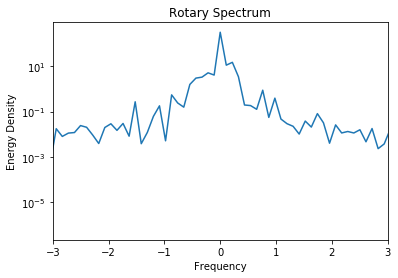

In [9]:
# plot rotary spectrum
plt.figure()
plt.plot(fq_k1_norm, amp_k1)
plt.xlim(-3,3)
#plt.ylim(10**0)

# plot labels
plt.title('Rotary Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Energy Density')
plt.yscale('log')
plt.show()